**Caroline Richards | 3688260102**

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

In [14]:
lifexp_df = pd.read_csv('/Users/richa/OneDrive/Documents/MATH 446/Datasets/new_life_expectancy.csv')
#fix the columns names.
lifexp_df.columns = lifexp_df.columns.str.strip().str.replace(pat="  ", repl=" ").str.replace(pat="[' '-/]", repl="_", regex=True).str.lower()
# Get rid of the missing life expectancy rows.
lifexp_df = lifexp_df.dropna(axis=0, subset=['life_expectancy'])

In [15]:
lifexp_df.status.value_counts()

status
Developing    2400
Developed      528
Name: count, dtype: int64

The status of a country indicate whether or not this specific data collector identifies certain countries as developed or developing as an indication of their economic and power status in the world. In this dataframe, status is a categorical variable. In order to use it in the linear regression model, it needs to be converted into a binary, numerical value where a value of 0 indicates a Developed country and value of 1 indicates a developing country. In order to complete this transformation, I utilize the pandas library "get_dummies" function to convert the status column into a dummy variable that can be utilized in regression analysis.

In [16]:
# "Status" feature as a dummy variable.
lifexp_df = pd.get_dummies(data=lifexp_df, drop_first=True, columns=['status'])
lifexp_df.head()

,country,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,...,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,status_Developing
0,Afghanistan,2015,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,True
1,Afghanistan,2014,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,...,8.18,62.0,0.1,612.696514,NaN,17.5,17.5,0.476,10.0,True
2,Afghanistan,2013,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,True
3,Afghanistan,2012,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,...,8.52,67.0,0.1,669.959000,NaN,17.9,18.0,0.463,9.8,True
4,Afghanistan,2011,59.2,275.0,71,0.01,NaN,68.0,3013,17.2,...,7.87,68.0,0.1,NaN,NaN,18.2,18.2,0.454,9.5,True


In [17]:
lifexp_df.groupby(['status_Developing'], as_index=False).agg(lambda x: 100 * x.isna().sum()/x.shape[0]).T.sort_values(ascending=False, by=[1, 0])

,0,1
population,60.037879,63.875
gdp,44.128788,43.791667
percentage_expenditure,40.340909,40.041667
adult_mortality,17.613636,17.833333
hepatitis_b,32.765152,15.833333
bmi,10.037879,10.791667
income_composition_of_resources,9.090909,10.083333
total_expenditure,6.25,8.041667
alcohol,5.492424,6.833333
schooling,9.090909,4.666667


In [37]:
lifexp_df.isna().sum().sort_values(ascending=False)

hepatitis_b                        553
adult_mortality                    521
bmi                                312
income_composition_of_resources    290
total_expenditure                  226
alcohol                            193
thinness_5_9_years                  32
thinness_1_19_years                 32
polio                               19
diphtheria                          19
hiv_aids                             0
schooling                            0
population                           0
gdp                                  0
country                              0
year                                 0
under_five_deaths                    0
measles                              0
percentage_expenditure               0
infant_deaths                        0
life_expectancy                      0
status_Developing                    0
dtype: int64

# I. Optimized Multilinear Regression

## a. Data Preprocessing

Below I will prepare the data for analysis by addressing zero values in specific columns, replacing those zero values with NaN , and using forward- and backward-filling methodology to impute any missing values based on the country of origin. By doing so, I will ensure that the data is in a suitable format for regression modeling.

In [71]:
reshaped_data_df = lifexp_df.copy()
reshaped_data_df = reshaped_data_df.sort_values(by=['country', 'year'], ascending=[True, False])
# Treating some zero values as NaN values
features = ['infant_deaths', 'percentage_expenditure', 'measles', 'under_five_deaths', 'income_composition_of_resources'] # features with lots of zeros
reshaped_data_df[features] = reshaped_data_df[features].replace(to_replace=0, value=np.nan) 
# Use the latest non-value to forward-fill missing values. 
reshaped_data_df = reshaped_data_df.groupby(['country']).transform(lambda x: x.fillna(method='ffill'))
reshaped_data_df['country'] = lifexp_df['country']
# Use the next non-value to back-fill missing values.
reshaped_data_df = reshaped_data_df.groupby(['country']).transform(lambda x: x.fillna(method='bfill'))
reshaped_data_df['country'] = lifexp_df['country']
reshaped_data_df.head(10)

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,...,diphtheria,hiv_aids,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,status_Developing,country
0,2015,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,19.1,83.0,...,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,True,Afghanistan
1,2014,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,86.0,...,62.0,0.1,612.696514,31731688.0,17.5,17.5,0.476,10.0,True,Afghanistan
2,2013,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,18.1,89.0,...,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,True,Afghanistan
3,2012,59.5,272.0,69.0,0.01,78.184215,67.0,2787.0,17.6,93.0,...,67.0,0.1,669.959000,26616792.0,17.9,18.0,0.463,9.8,True,Afghanistan
4,2011,59.2,275.0,71.0,0.01,79.679367,68.0,3013.0,17.2,97.0,...,68.0,0.1,553.328940,26616792.0,18.2,18.2,0.454,9.5,True,Afghanistan
5,2010,58.8,279.0,74.0,0.01,79.679367,66.0,1989.0,16.7,102.0,...,66.0,0.1,553.328940,26616792.0,18.4,18.4,0.448,9.2,True,Afghanistan
6,2009,58.6,281.0,77.0,0.01,56.762217,63.0,2861.0,16.2,106.0,...,63.0,0.1,445.893298,26616792.0,18.6,18.7,0.434,8.9,True,Afghanistan
7,2008,58.1,287.0,80.0,0.03,25.873925,64.0,1599.0,15.7,110.0,...,64.0,0.1,373.361116,26616792.0,18.8,18.9,0.433,8.7,True,Afghanistan
8,2007,57.5,295.0,82.0,0.02,364.975229,63.0,1141.0,15.2,113.0,...,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4,True,Afghanistan
9,2006,57.3,295.0,84.0,0.03,364.975229,64.0,1990.0,14.7,116.0,...,58.0,0.1,272.563770,24118979.0,19.2,19.3,0.405,8.1,True,Afghanistan


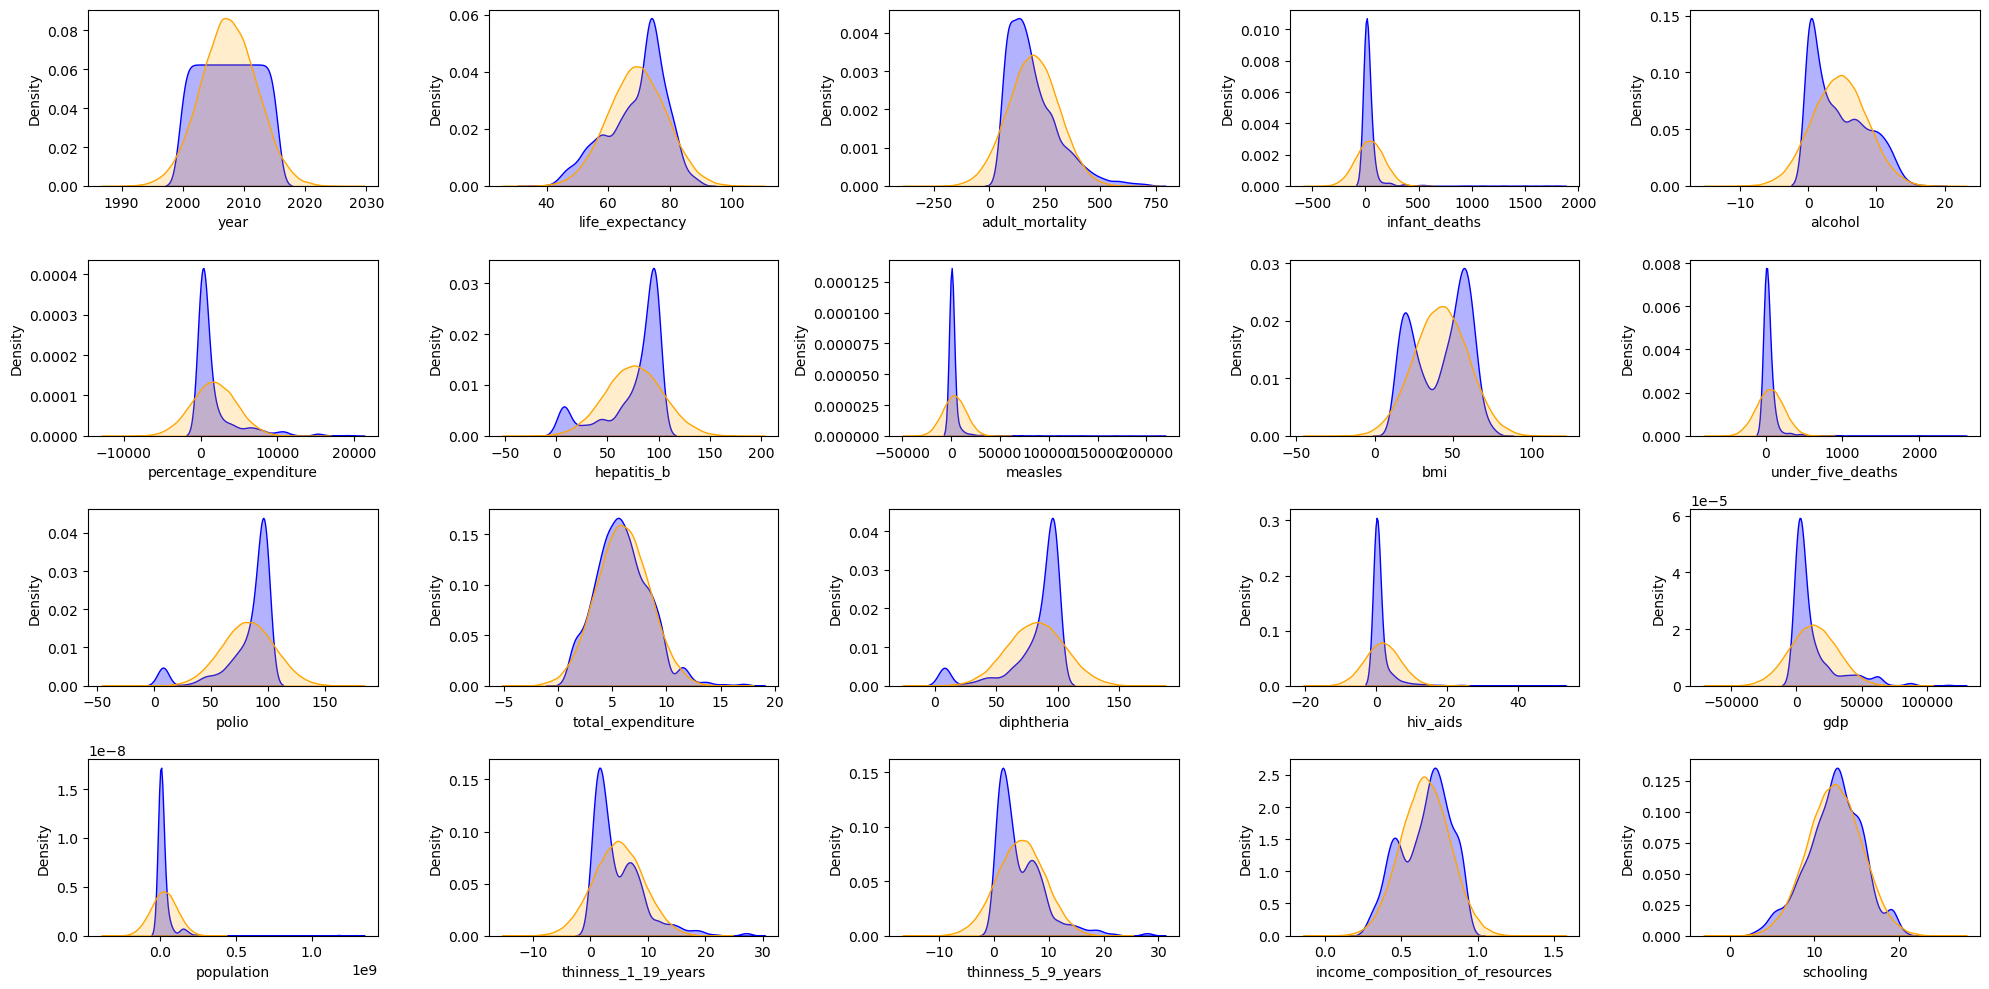

In [32]:
df = reshaped_data_df.drop(columns=['country', 'status_Developing'])
df = df.where(df > 0, np.nan)

fig, ax = plt.subplots(4, 5)
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True

from itertools import product
lst = [np.arange(0, 4), np.arange(0, 5)]
couples = product(*lst) 

for i, j in couples:
    feature = df.columns[5 * i + j]
    values = df[feature]
    ave = values.mean()
    sd = values.std()
    sns.kdeplot(x=values, fill=True, alpha=0.3, color='blue', ax=ax[i, j]);
    sns.kdeplot(x=np.random.normal(loc=ave, scale=sd, size=100000), fill=True, alpha=0.2, color='orange', ax=ax[i, j]);

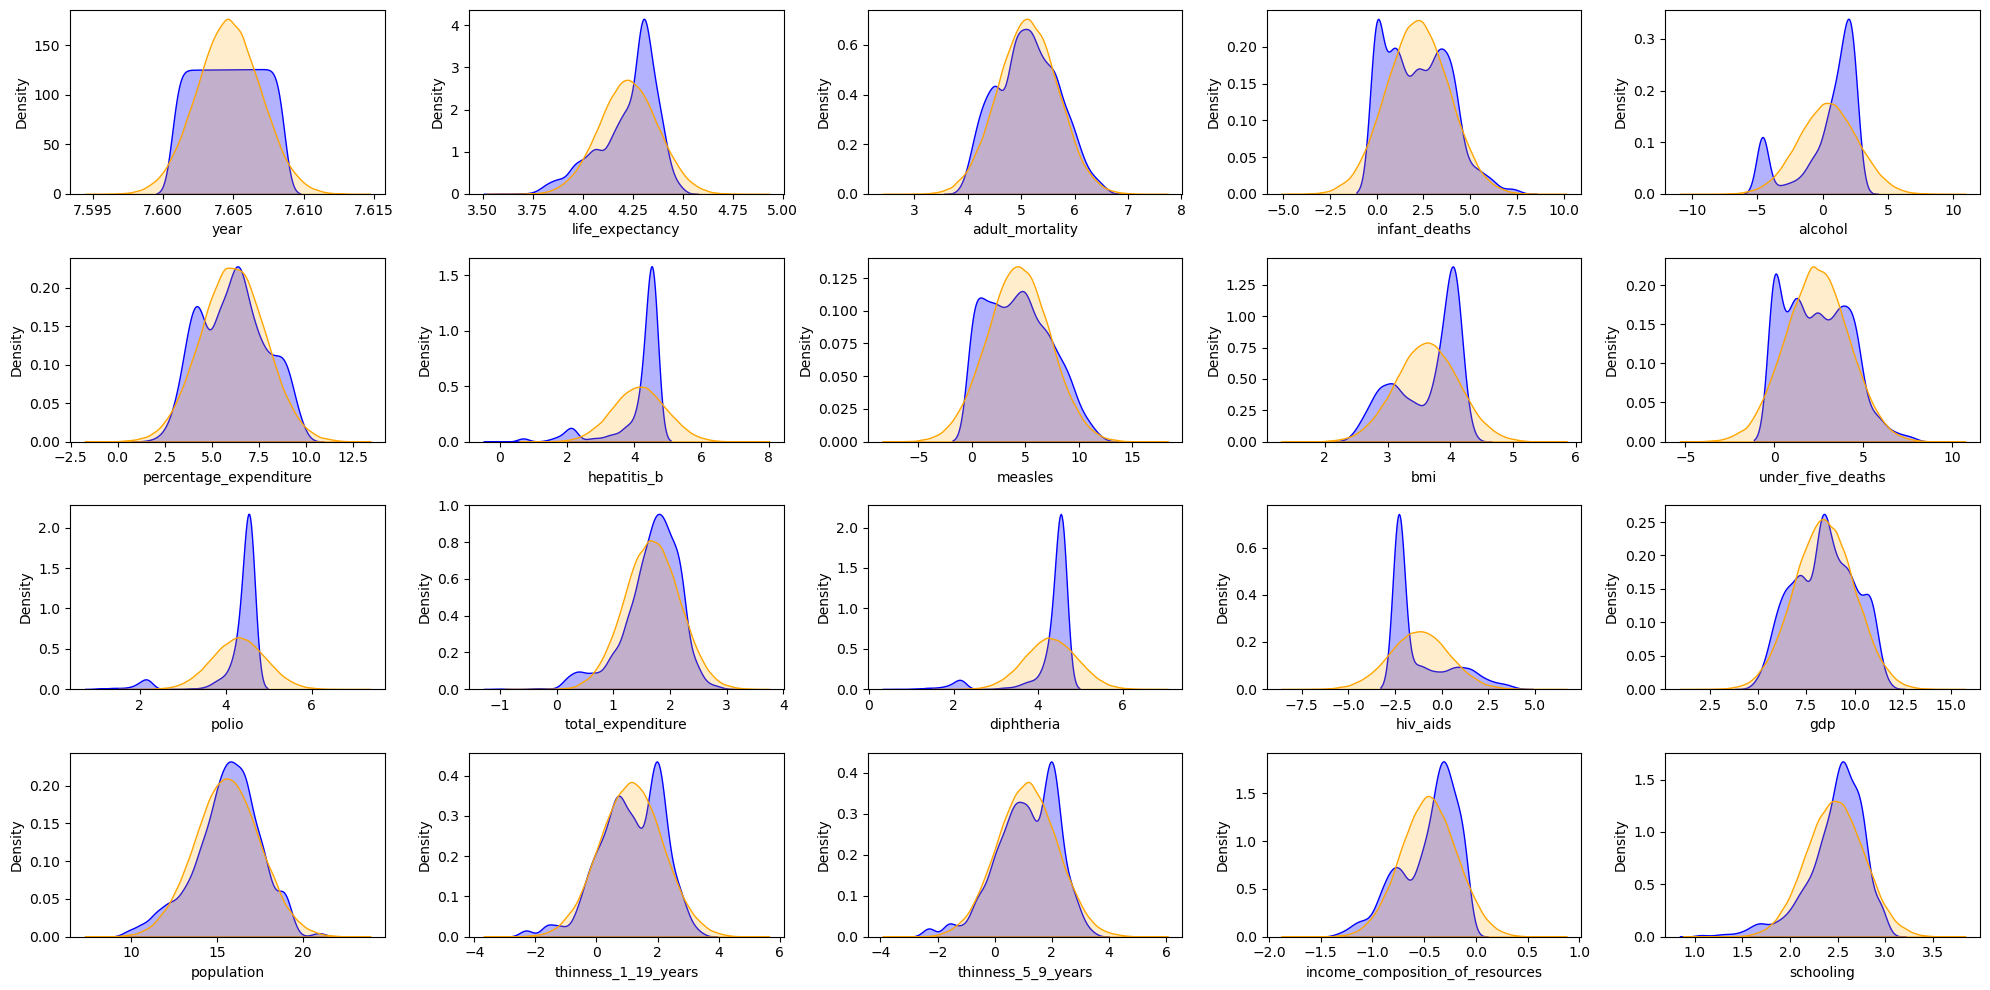

In [33]:
log_df = np.log(df.where(df > 0, np.nan))

fig, ax = plt.subplots(4, 5)
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True

from itertools import product
lst = [np.arange(0, 4), np.arange(0, 5)]
couples = product(*lst) 

for i, j in couples:
    feature = log_df.columns[5 * i + j]
    log_values = log_df[feature]
    ave = log_values.mean()
    sd = log_values.std()
    sns.kdeplot(x=log_values, fill=True, alpha=0.3, color='blue', ax=ax[i, j]);
    sns.kdeplot(x=np.random.normal(loc=ave, scale=sd, size=100000), fill=True, alpha=0.2, color='orange', ax=ax[i, j]);

In the above two processes, I utilize the Seaborn library function for Kernel Density Estimation (KDE) plots. the KDE plots allow me to estimate the probability density of each feature variable as if they were continuous random variables. I created two separate versions where I am comparing the regular variable density plots to the logarithmic transformation of each variable in order to determine how best to represent each feature in my linear regression model. In observation of the above graphs, the following features appear to be better represented as logarithmic transformations: adult_mortality, 
infant_death, 
percentage_expenditu, e
meas, es
under_five_de, e.., 
gdp
pop, lation
thinness_1_, and 9_years
thinness_. These features should be represented in logarithmic transformations because their density curves under this transformation appear to be more normalized than the untransformed feature, suggesting that a logarithmic transformation of the feature is a better fit for the optimized linear model.5_9_years

## b. Target Variables & Testing Sets

In [41]:
X = reshaped_data_df.copy()
X = reshaped_data_df.drop(columns=['country', 'year', 'life_expectancy'])

scaler = StandardScaler()
scaler.fit(X)
X_rescaled = scaler.transform(X)

y = lifexp_df['life_expectancy'].values

To proceed with my analysis, I created 'reshaped-data-df' as a dataframe 'X' so I can avoid manipulating and modifying the original dataset by mistake. I proceed to drop the country, year, and life expectancy columns. Country is categorical identifier, year is a time-series identifier, and life expectancy is my target variable so these values are not useful to me in my regression analysis to predict life expectancy.
I proceed to utilize the 'StandardScaler' function to standardize the data in the 'X' dataframe to ensure that all features are normalized with a mean of 0 and a standarad deviaiton of 1. This will prevent features with larger magnitudes from controlling the model. I then convert the X dataframe to the name frame 'X-rescaled'.

In [42]:
# KNN to infer missing values 
knn_inputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
knn_inputer.fit(X_rescaled)
knn_inputer.transform(X_rescaled)

array([[ 0.57540679,  0.15542692, -1.11080754, ..., -1.08449647,
        -0.62203716,  0.46904158],
       [ 0.6442152 ,  0.17019813, -1.11080754, ..., -1.1030028 ,
        -0.6509774 ,  0.46904158],
       [ 0.61841204,  0.18496934, -1.11080754, ..., -1.14001545,
        -0.67991763,  0.46904158],
       ...,
       [ 4.46308184, -0.11784044, -0.02450771, ..., -1.40527277,
        -0.6509774 ,  0.46904158],
       [ 4.21365136, -0.11784044, -0.69054222, ..., -1.40527277,
        -0.70885787,  0.46904158],
       [ 4.03302929, -0.12522605, -0.70037299, ..., -1.36209134,
        -0.70885787,  0.46904158]])

In order to ensure proper execution of the linear regression analysis, I ensure that any remaining null values in the X-rescaled dataframe are address by using the k-nearest neighbors imputation technique. In this technique, I specify the consideration of the nearest 5 values to a missing value with simlar features in  order to impute a missing value. I specify that this should be done with a distance specific weight so that closer neighbor values will have a greater influence on the imputation of the missing value. I then apply the k-nearest neighbors imputer to the X-rescaled dataframe before finally transforming the X-rescaled dataframe with the imputer inorder to rescale the feature data.

In [46]:
features = reshaped_data_df[['status_Developing', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 
                 'hepatitis_b', 'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure', 'diphtheria', 
                 'hiv_aids', 'gdp', 'population', 'thinness_1_19_years', 'thinness_5_9_years', 'income_composition_of_resources', 'schooling']]
target = lifexp_df['life_expectancy']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
imputer = SimpleImputer(strategy = 'mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
X_train = pd.DataFrame(X_train)
X_train.dropna(inplace=True)
X_test = pd.DataFrame(X_test)
X_test.dropna(inplace=True)

To begin regression analysis, I split the data into features from the reshaped datframe and the traget value of life-expectancy from the lifeexp_df dataframe. In order to address unstandaradized and missing data due to secondary and tertiary transformations previously performed, I apply a standardization method and simple imputation to infer any missing values and transform the dataframe to a normalized/standardized dataset.

## c. Evaluation

In [52]:
op_model = LinearRegression()
op_model.fit(X_train, y_train)
y_pred = op_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 5.262033849004643
R-squared: 0.9399168392772083


I use the trained model to make predicitons on the testing dataframe. I then calculate the mean-squared error (MSE) and the R-squared value for the values calculated utilizing the model to evaluate my model. My mean-squared error of 5.262 indicates a less than perfect prediction model. Additionally, my $r^2$ value of 0.9399 indicates a strong correlation between my independent and dependent variables. While my basic optimized muotilinear regression model may not be perfect, my $r^2$ value indicates that the features can explain about 93.9% of the variance in life expectancy for a country.

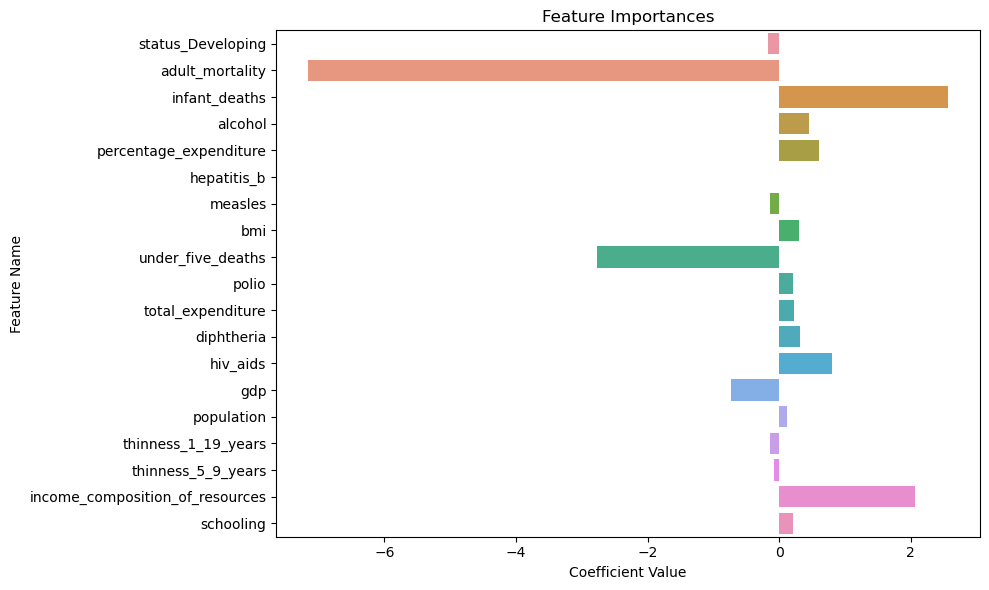

In [53]:
coefficients = model.coef_
feature_names = features.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients, y=feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Feature Importances')
plt.show()

The above barplot shows the all of the features and their coefficient values. The plot represents how important each coefficient is in the prediciton of life expectancy.  In part three, I will evaluate a model with values that seem to be of indicative importance in this barplot. The variables which seem to be the most influential in this model are as follows: adult_mortality, infant_deaths, under_five_deaths, income_composition_of_resources, hiv_aids, gdp, percentage_expenditure, and alcohol (in respective order).

# II. Optimized Multilinear Regression w/ PCA

In [56]:
pca_df = pd.read_csv('/Users/richa/OneDrive/Documents/MATH 446/Datasets/new_life_expectancy.csv')
pca_df.columns = pca_df.columns.str.strip().str.replace(pat="  ", repl=" ").str.replace(pat="[' '-/]", repl="_", regex=True).str.lower()
pcafeatures = pca_df.drop(['country', 'year', 'status', 'life_expectancy'], axis=1)
pcatarget = pca_df['life_expectancy']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

I seek to compare my initial model to a different optmized multilinear regression model utilied pincipal component analysis. To do so, I reload my data to a new dataframe, clean the columns, and drop unnescesssary features. Additionally, I identify life_expectancy as my target variable. I then separate mydataframe into training and testing splits using the train_test_splut function in order to train my model and predict the target variable of life-expectancy with my model.

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

imputer = SimpleImputer(strategy = 'mean')
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.dropna(inplace=True)
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.dropna(inplace=True)

pca = PCA(n_components=10) 
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In the above, I apply standardization scalers to the data features in order to normalize the data for subsequent analysis and modeling to ensure that the features are all scaled the same. I then utilize the SimpleImputer to impute missing values with the feature mean for both the trianing and testing datasets to ensure proper execution of modeling and analysis. For any further missing values, I convert the dataframes to pandas dataframes and apply row-removal methods to handle remaining missing vlaues. I then apply principle component analysis to the data by using dimensionality reduction to reduce the number of features while keeping important data on both the training and testing datasets.

In [60]:
pcamodel = LinearRegression()
pcamodel.fit(X_train_pca, y_train)

LinearRegression()

## Evaluation

In [61]:
train_score = pcamodel.score(X_train_pca, y_train)
test_score = pcamodel.score(X_test_pca, y_test)

print(f"Training R-squared: {train_score:.2f}")
print(f"Testing R-squared: {test_score:.2f}")

Training R-squared: 0.87
Testing R-squared: 0.87


In [70]:
y_pred = pcamodel.predict(X_test_pca)
pca_mse = mean_squared_error(y_test, y_pred)
pca_r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (PCA):", pca_mse)
print("R-squared (PCA):", pca_r2)

Mean Squared Error (PCA): 11.451483899069487
R-squared (PCA): 0.8692442186109459


To evaluate the performance of my optimized multilinear regression model built utilizing principle component analysis, I I cculate the r-squared values for each dataset to determine how well the model explains the variance in life-expectancy. By calcualting both datasets $r^2$ scores I can evaluate how well the model generalizes unknown data where the test-data allows an important indication for overfitting. Both $r^2$ values are 0.87, indicating a good generalized model cpanle of explaining a substantial amount of variance with a low-risk of overfitting since the model exhibits consistent performance on different data subsets. In conclusion, this model is failry reliable in prediting life-expectancy.

# III. Additional Strategies

## a. Secondary Regression Analysis

In [73]:
newfeatures = reshaped_data_df[[ 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 
                  'under_five_deaths','hiv_aids', 'gdp', 'population', 'income_composition_of_resources', 'schooling']]
target = lifexp_df['life_expectancy']
X_train, X_test, y_train, y_test = train_test_split(newfeatures, target, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
imputer = SimpleImputer(strategy = 'mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
X_train = pd.DataFrame(X_train)
X_train.dropna(inplace=True)
X_test = pd.DataFrame(X_test)
X_test.dropna(inplace=True)

In [74]:
new_model = LinearRegression()
new_model.fit(X_train, y_train)
y_pred = new_model.predict(X_test)
new_mse = mean_squared_error(y_test, y_pred)
new_r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", new_mse)
print("R-squared:", new_r2)

Mean Squared Error: 5.567372729578154
R-squared: 0.9364304069275027


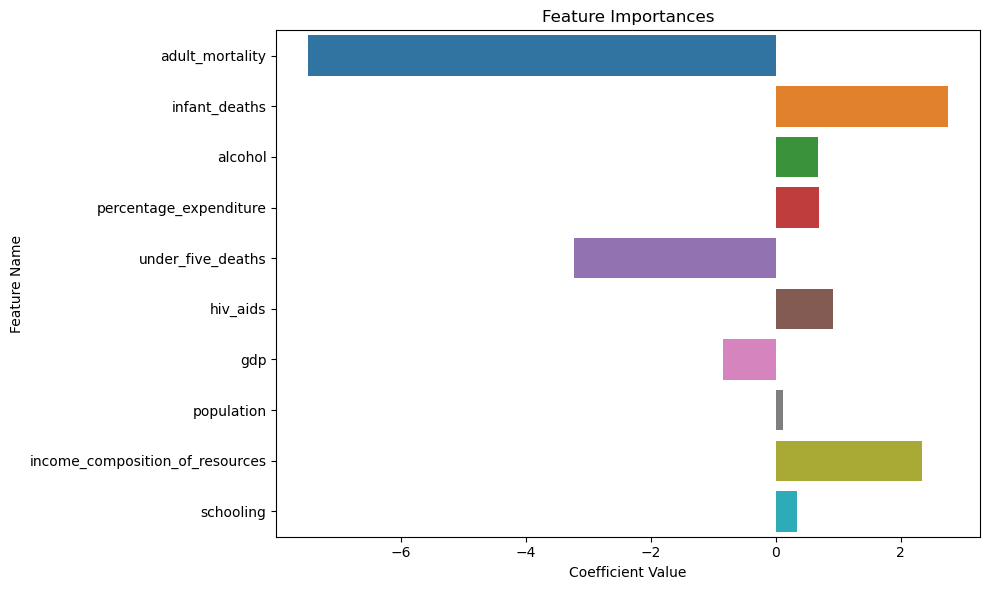

In [76]:
coefficients = new_model.coef_
feature_names = newfeatures.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients, y=feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Feature Importances')
plt.show()

As indicated by the $r^2$ value and mean-squared error analysis done on the simplified multilinear regression model. Removing less influential variables does no impact the fit of the model by as much as expected. In fact both statistical measures show very little change indicating a lack of significant omitted variable bias in the simpler model.

## b. Developing v. Developed countries

In [78]:
life_dict = {
    'Developing': {
        'avg': reshaped_data_df.loc[reshaped_data_df['status_Developing'] == 1, 'life_expectancy'].mean(),
        'median': reshaped_data_df.loc[reshaped_data_df['status_Developing'] == 1, 'life_expectancy'].median()
    },
    'Developed': {
        'avg': reshaped_data_df.loc[reshaped_data_df['status_Developing'] == 0, 'life_expectancy'].mean(),
        'median': reshaped_data_df.loc[reshaped_data_df['status_Developing'] == 0, 'life_expectancy'].median()
    }
}
life_df = pd.DataFrame(life_dict)
life_df = life_df.T
print(life_df)

                  avg  median
Developing  67.010750    69.0
Developed   79.289394    79.3


In the above analysis, I separate and aggregate the life expectancy data frame into subsets based on developing status. I then calculate the mean and median life expectancy for each category. By adding these subsets to a dictionary and converting the dictionary to a data frame I am then able to display the results in a more understandable visual table.

Regression Analysis for Developing Countries
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     3242.
Date:                Mon, 23 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:18:55   Log-Likelihood:                -5449.5
No. Observations:                2400   AIC:                         1.092e+04
Df Residuals:                    2389   BIC:                         1.098e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

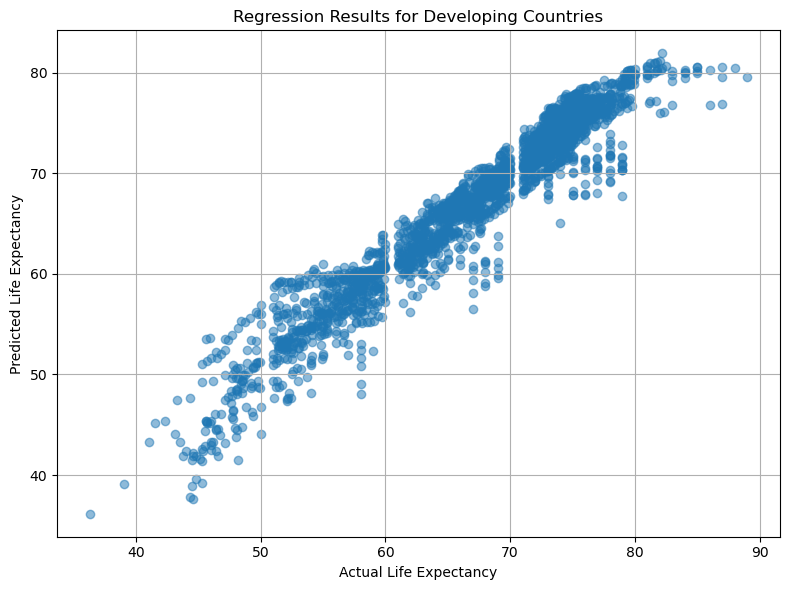

Regression Analysis for Developed Countries
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     124.0
Date:                Mon, 23 Oct 2023   Prob (F-statistic):          3.94e-123
Time:                        09:18:56   Log-Likelihood:                -1169.6
No. Observations:                 528   AIC:                             2359.
Df Residuals:                     518   BIC:                             2402.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1      

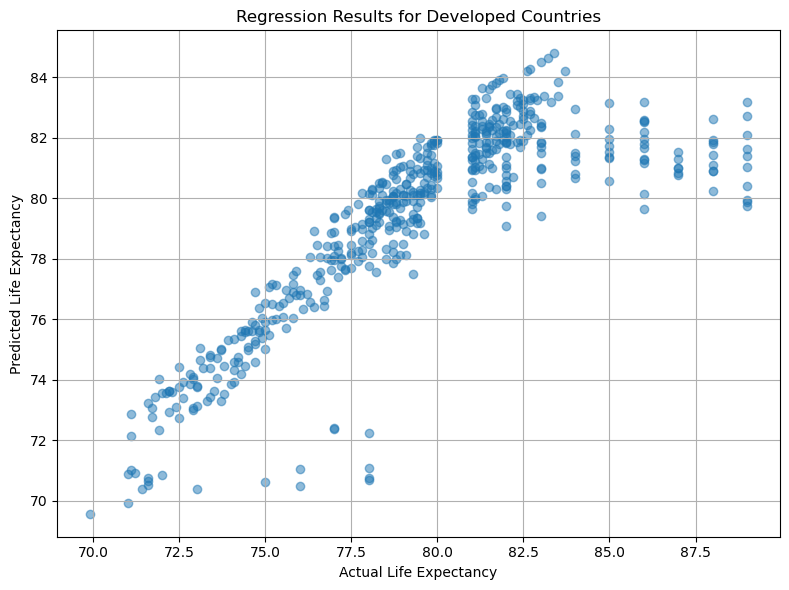

In [87]:
# data split
developing_data = reshaped_data_df[reshaped_data_df['status_Developing'] == 1]
developed_data = reshaped_data_df[reshaped_data_df['status_Developing'] == 0]

def run_regression(data, group_name):
    # Define independent/dependent variables and intercept 
    X = data[['adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 
                  'under_five_deaths','hiv_aids', 'gdp', 'population', 'income_composition_of_resources', 'schooling']]
    X = sm.add_constant(X) 
    y = data['life_expectancy']
    # Handling missing values
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    # Fit an OLS regression model
    model = sm.OLS(y, X).fit()
    # Print regression results for the group
    print(f"Regression Analysis for {group_name} Countries")
    print(model.summary())

    predicted_life_expectancy = model.predict(X)
    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(data['life_expectancy'], predicted_life_expectancy, alpha=0.5)
    plt.title(f'Regression Results for {group_name} Countries')
    plt.xlabel('Actual Life Expectancy')
    plt.ylabel('Predicted Life Expectancy')
    plt.grid(True)
    plt.show()


run_regression(developing_data, 'Developing')
run_regression(developed_data, 'Developed')


In the above I split the life-expectancy dataframe into two groups: developing countries and developed countries. For each group, I run a regression analysis and plot the predicted versus actual results on a graph to indicate how acurate the model is. In my regression analysis for developing countries, my model has an $r^2$ value of 0.931 indicating that 93.1% of the variation in life expectancy is explained by my chosen independent variables. This is a strong model. In my regression analysis for developed countries, my model has an $r^2$ value of 0.683 indicating that only 68.3% of the variation in life expectancy is explained by my chosen independent variables. This model is not as strong compared to the developing countries model. X1 through X10 are the coefficients, standard error, t-statistic, and p-value which correspond to the following respectively: 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'under_five_deaths','hiv_aids', 'gdp', 'population', 'income_composition_of_resources', and 'schooling'. 

The developing countries model indicates that every varibale except population is statistically significant in explaining life expectancy. For both models, adult mortality, infant deaths, under five deaths, hiv and aids, and income composition of resources are the most significant factors in predicting life expectancy.